# AI Coursework: Predicting Dementia Status from MRI Brain Images

Using a convolution neural network model

## Dependencies, Path and Parameters

In [ ]:
# conda activate tf - for specific environment

In [1]:
!pip install scikit-learn
!pip install numpy
!pip install matplotlib
!pip install opencv-python

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from collections import Counter
from tqdm import tqdm
from sklearn.model_selection import train_test_split
! pip install pillow
from PIL import Image

In [3]:
#Define the path for the images of the brain MRI scans
path = '/Users/maisievarcoe/Desktop/AI/Coursework/images'

original_dataset = os.path.join(path, 'Originals')
augmented_dataset = os.path.join(path, 'augmented_dataset')

In [4]:
classes = ["NoImpairment", "MildImpairment", "ModerateImpairment"]
num_augmented_per_image =5
valid_ext = ('.png', '.jpg', '.jpeg')

In [5]:
# Create augmented folder if it does not exist 
for cls in classes:
    os.makedirs(os.path.join(augmented_dataset, cls), exist_ok = True)

## Load Images

In [6]:
from concurrent.futures import ThreadPoolExecutor, as_completed


#Define function to load the images
def load_images(directories, valid_ext=(".jpg", ".png"), target_size=(224,224), max_workers=8):
    images = [] #stores image arrays
    labels = [] #stores class label for each image

    # Loads and resizes each image
    def load_single_image(file_path, label):
        img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, target_size)
            return img, label
        return None

    # Prepare list of all files with labels
    all_files = []
    for label, sub_dir in enumerate(directories):
        files = [f for f in os.listdir(sub_dir) if f.lower().endswith(valid_ext)]
        all_files.extend([(os.path.join(sub_dir, f), label) for f in files])

    # Load images in parallel with progress bar
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(load_single_image, fpath, lbl) for fpath, lbl in all_files]
        for future in tqdm(as_completed(futures), total=len(futures), desc="Loading images", unit="img"):
            result = future.result()
            if result is not None:
                img, lbl = result
                images.append(img)
                labels.append(lbl)
                
    return np.array(images), np.array(labels)


    
    #loop through directories and assign labels 
    #for label, sub_dir in enumerate(directories):
     #   file_list = [f for f in os.listdir(sub_dir) if f.lower().endswith(valid_ext)]
    
      #  num_loaded = 0
        #loop through every file in folder with progress bar 
       # for file_name in tqdm(
        #    file_list,
         #   desc=f"Loading {os.path.basename(sub_dir)}",
          #  unit="img",
           # total=len(file_list)
        #):   

            #load each image, if not image = None    
         #   img_path = os.path.join(sub_dir, file_name)
          #  img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) #load as greyscale
            
           # if img is not None:                
            #    img = cv2.resize(img, (224, 224))  # Resizes images to consistent shape
             #   images.append(img) #append processed image and its label
              #  labels.append(label)
               # num_loaded += 1
    #return np.array(images), np.array(labels)


In [7]:
# Load original images
dirs = [os.path.join(original_dataset, cls) for cls in classes]
images_original, labels_original = load_images(dirs)
print(f"Loaded {len(images_original)} images")
print(Counter(labels_original))

Loading images: 100%|███████████████████████████████████████████████████████████████████████| 5076/5076 [01:13<00:00, 69.33img/s]


Loaded 5076 images
Counter({np.int64(0): 2560, np.int64(1): 1792, np.int64(2): 724})


## Train/Test Split

In [8]:
# Split original images
X_train, X_test, y_train, y_test = train_test_split(
    images_original,
    labels_original,
    test_size=0.2,
    random_state=142,
    stratify=labels_original
)

In [9]:
# Normalize and add channel dimension
X_test = X_test / 255.0
X_test = X_test[..., np.newaxis]

## Image Augmentation

In [10]:
from PIL import Image, ImageEnhance, ImageFilter

def augment_image(img):

    img_aug = img.copy()

    # Convert NumPy → PIL
    img = Image.fromarray(img)

    # Rotation
    img_aug = img.rotate(np.random.randint(-10, 10))  

    # Horizontal flip 
    if np.random.rand() > 0.5:
        img_aug = img_aug.transpose(Image.FLIP_LEFT_RIGHT)

    # Brightness and contrast 
    img_aug = ImageEnhance.Brightness(img_aug).enhance(np.random.uniform(0.9, 1.1))
    img_aug = ImageEnhance.Contrast(img_aug).enhance(np.random.uniform(0.9, 1.1))

    # Optional Gaussian blur
    if np.random.rand() > 0.7:
        blur_radius = np.random.uniform(0.5, 1.0)
        img_aug = img_aug.filter(ImageFilter.GaussianBlur(radius=blur_radius))

    # CLAHE (Contrast Limited Adaptive Histogram Equalisation)
    #if np.random.rand() > 0.5:
     #   clahe = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(8,8))
      #  img_cv = clahe.apply(img_cv)

    return np.array(img_aug)

### Augment Training Set Only

In [11]:
#augment training set with weighted augmentations based on ratio images in each classes 
augmentation_factors = {
    0: 0.1,   # NoImpairment
    1: 0.5,   # Mild
    2: 2.0    # Moderate
}

X_train_balanced = list(X_train)
y_train_balanced = list(y_train)

for cls, factor in augmentation_factors.items():
    cls_indices = np.where(y_train == cls)[0]
    num_aug = int(len(cls_indices) * factor)

    for _ in range(num_aug):
        idx = np.random.choice(cls_indices)
        aug_img = augment_image(X_train[idx])
        X_train_balanced.append(aug_img)
        y_train_balanced.append(cls)


(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

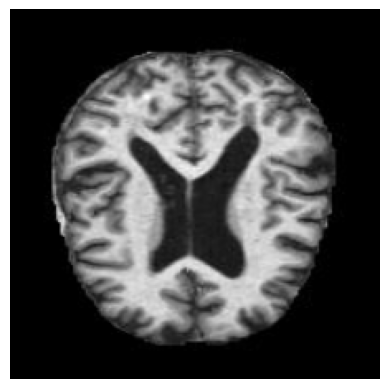

In [19]:
plt.imshow(X_train_balanced[500], cmap='gray')
plt.axis('off')

In [12]:
# Convert to NumPy arrays
X_train_combined = np.array(X_train_balanced)
y_train_combined = np.array(y_train_balanced)

In [13]:
print("X_train_combined shape:", X_train_combined.shape)
print("y_train_combined shape:", y_train_combined.shape)
print("Training label distribution:", Counter(y_train_combined))


X_train_combined shape: (6138, 224, 224)
y_train_combined shape: (6138,)
Training label distribution: Counter({np.int64(0): 2252, np.int64(1): 2149, np.int64(2): 1737})


## Normalise and Add Channel Dimension

In [14]:
X_train_combined = X_train_combined.astype('float16') / 255.0
X_test = X_test.astype('float16') / 255.0

X_train_combined = X_train_combined[..., np.newaxis]
X_test = X_test[..., np.newaxis]


In [15]:
print("Training set shape:", X_train_combined.shape)
print("Test set shape:", X_test.shape)
print("Training label distribution:", Counter(y_train_combined))
print("Test label distribution:", Counter(y_test))


Training set shape: (6138, 224, 224, 1)
Test set shape: (1016, 224, 224, 1, 1)
Training label distribution: Counter({np.int64(0): 2252, np.int64(1): 2149, np.int64(2): 1737})
Test label distribution: Counter({np.int64(0): 512, np.int64(1): 359, np.int64(2): 145})


In [22]:
num_original = len(X_train)
num_total = len(X_train_combined)

print("Original training images:", num_original)
print("Total training images:", num_total)


Original training images: 4060
Total training images: 6138


In [38]:
class_colors = {
    0: "tab:blue",     # NoImpairment
    1: "tab:orange",   # MildImpairment
    2: "tab:red"       # ModerateImpairment
}


In [46]:
import matplotlib.pyplot as plt
import numpy as np

def show_augmented_only_with_titles(
    X, y, class_names, start_idx, num_images=4
):
    num_classes = len(class_names)

    # Wide and short figure for slides
    plt.figure(figsize=(num_images * 4, num_classes * 2.5))

    plot_idx = 1

    for cls in range(num_classes):
        # get augmented images for this class
        cls_indices = np.where(
            (y == cls) & (np.arange(len(y)) >= start_idx)
        )[0][:num_images]

        for idx in cls_indices:
            plt.subplot(num_classes, num_images, plot_idx)
            plt.imshow(X[idx].squeeze(), cmap="gray")
            plt.axis("off")

            # Add a label above each image
            plt.title(f"{class_names[cls]} (label {cls})", fontsize=10)

            plot_idx += 1

    plt.tight_layout()
    plt.show()



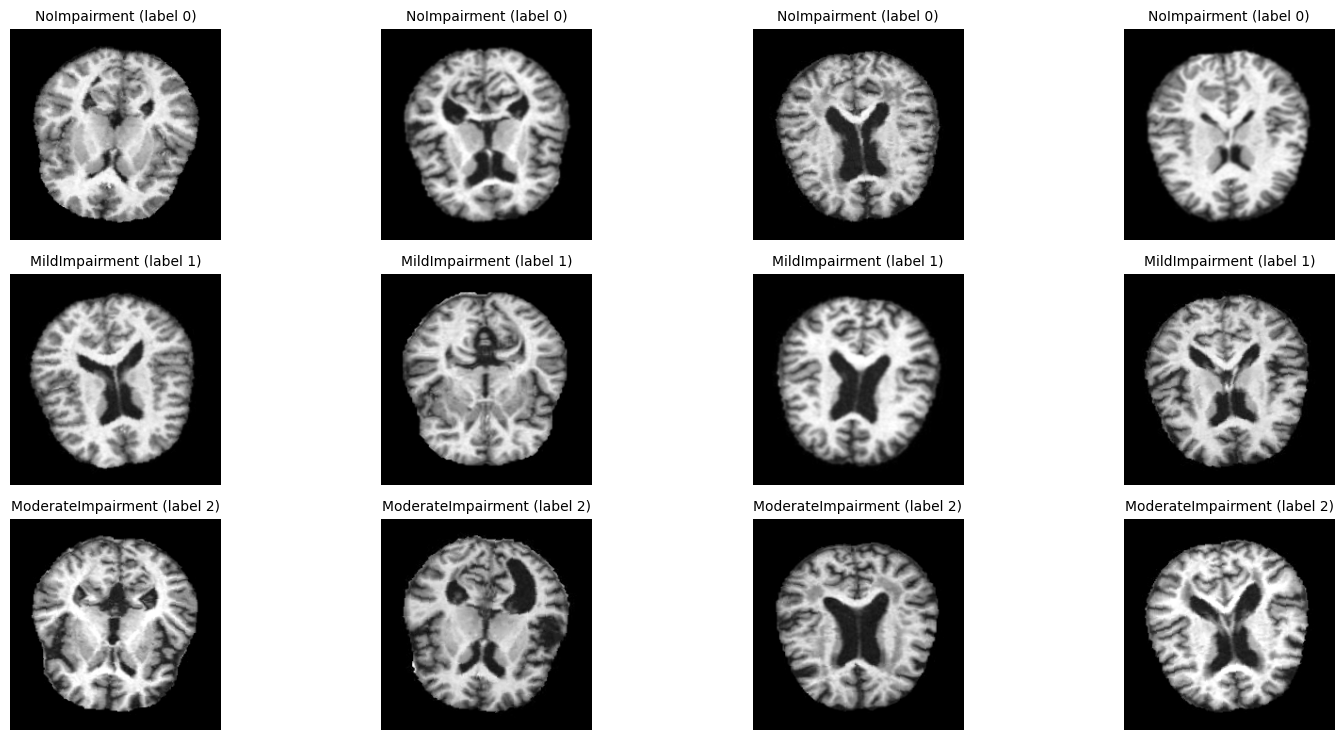

In [48]:
show_augmented_only_with_titles(
    X_train_combined,
    y_train_combined,
    classes,
    start_idx=num_original,
    num_images=4
)



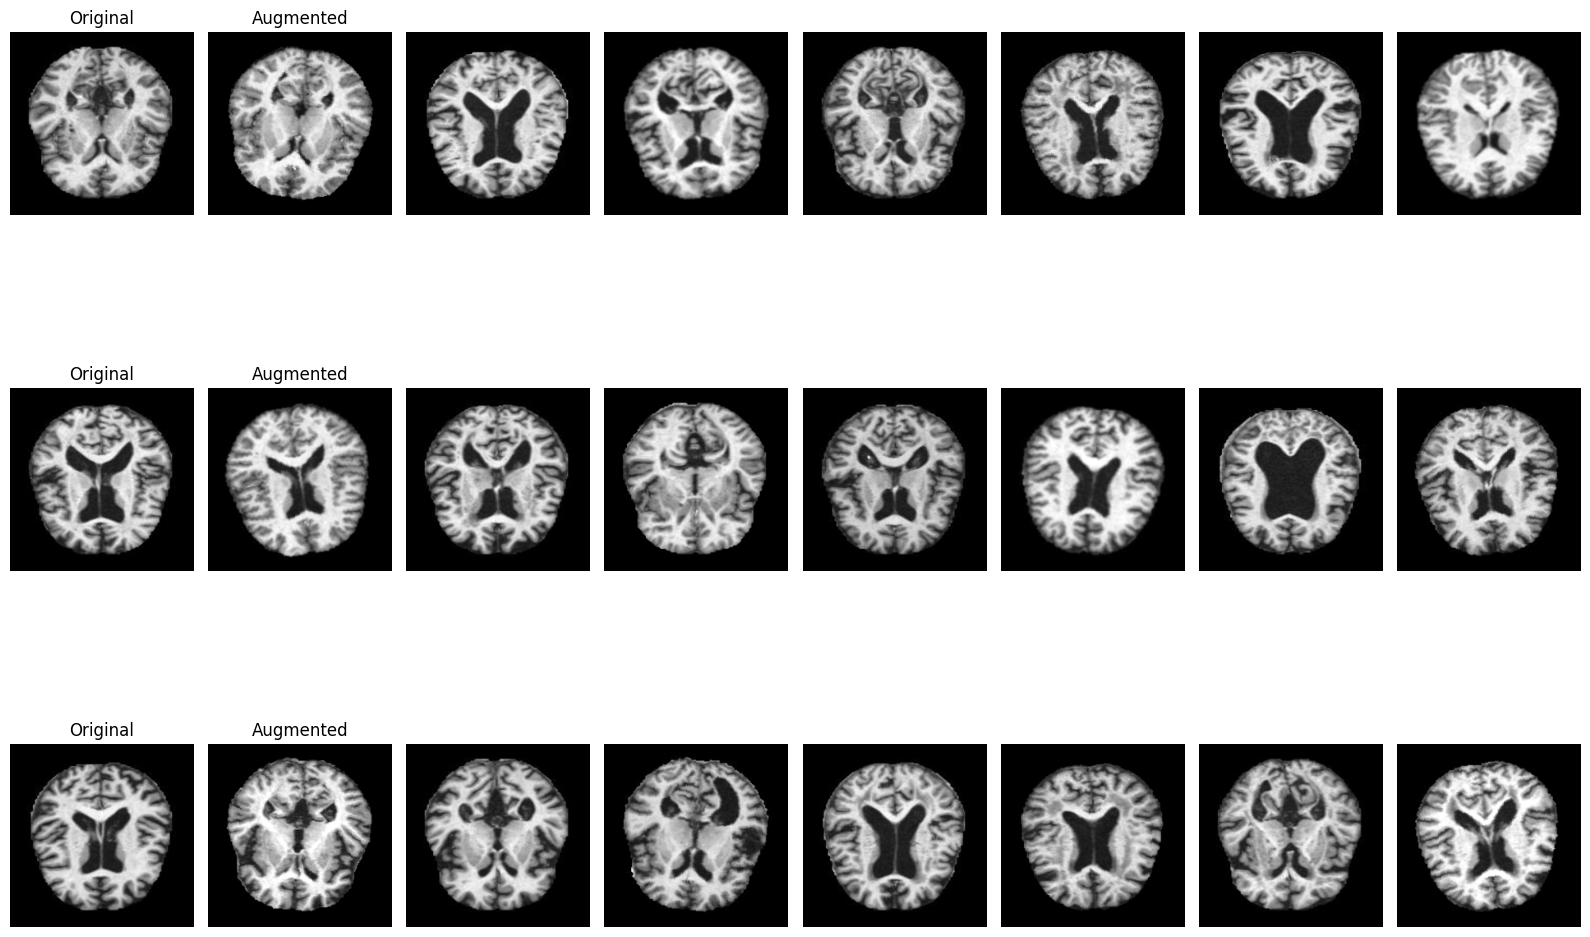

In [40]:
show_original_vs_augmented(
    X_train, y_train,
    X_train_combined, y_train_combined,
    classes,
    start_aug_idx=num_original,
    num_images=4
)


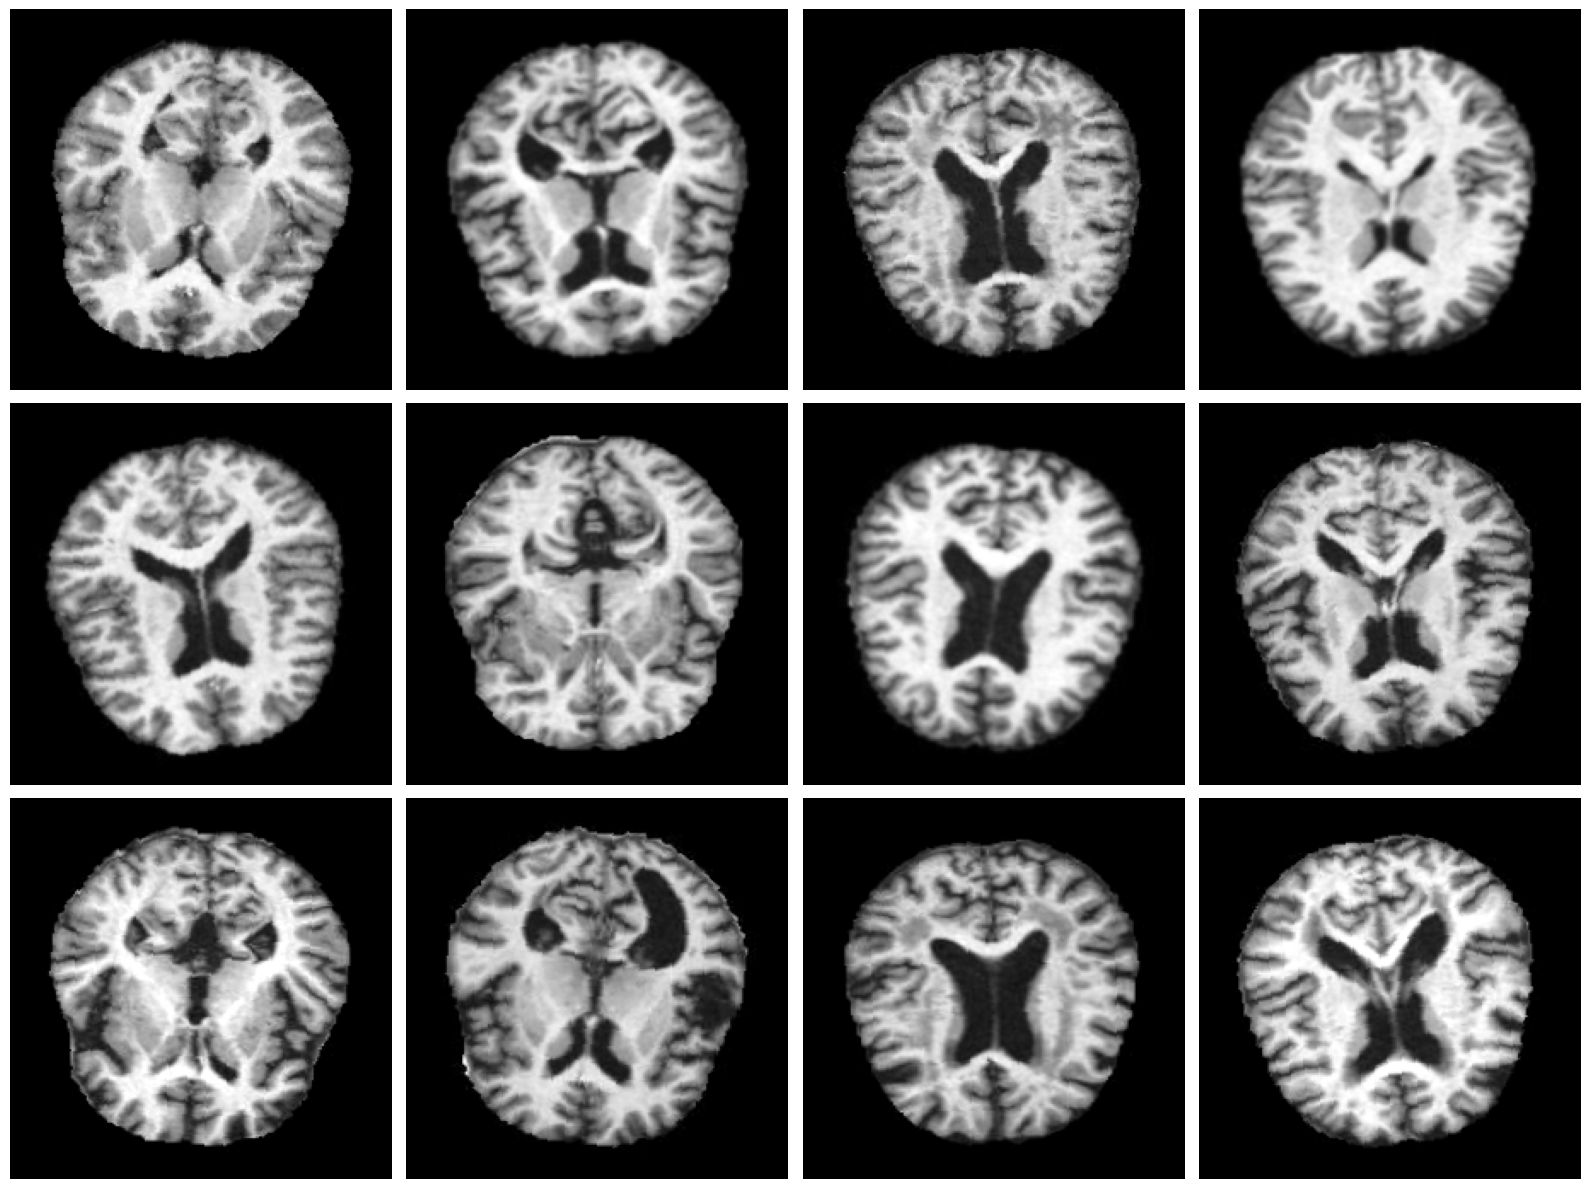

In [37]:
show_augmented_images_per_class(
    X_train_combined,
    y_train_combined,
    classes,
    start_idx=num_original,
    num_images=4
)



## Train CNN Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Input

### Define CNN Architechture 

BatchNormalization improves training stability

Dropout helps prevent overfitting on augmented data

Softmax is standard for multi-class classification

In [ ]:
model = Sequential([
    Input(shape = (224, 224, 1)),  # Grayscale images
    Conv2D(32, (3,3), activation='relu', padding='same'), #Conv detects edges, textures, subtle brain patterns
    BatchNormalization(),
    MaxPooling2D((2,2)), # Reduces spatial size, keeps important features

    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Flatten(), # Combine features for classification 
    Dense(128, activation='relu'),
    Dropout(0.5),

    Dense(3, activation='softmax')  # Outputs three probabilities (one for each class)
])



In [ ]:
# Compile the model using sparse categorical crossentropy (becuase labels are integers)
model.compile(
    optimizer=Adam(learning_rate=1e-4),

    # Loss compares predicted probabilities to the true label, e.g. penalty 
    loss='sparse_categorical_crossentropy',  # y_train are integer labels
    metrics=['accuracy']
)

In [ ]:
# Callbacks, stops early if model stops improving, reduces learning rate when validation loss plateaus, saves best model automatically 
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6
)


In [ ]:
# Pays more attention to minority classes when computing loss 
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Classes: 0,1,2
classes = np.unique(y_train_combined)

# Compute class weights automatically
class_weights = compute_class_weight(
    class_weight='balanced',  # inversely proportional to class frequency
    classes=classes,
    y=y_train_combined
)

# Convert to dict for Keras
class_weight_dict = dict(zip(classes, class_weights))

print("Class weights:", class_weight_dict)


In [ ]:
# Takes batch of images and passes them through the CNN layers 
# The CNN extracts features at different spatial states 
# Computes gradients of loss for every trainable weight in the model 
# Adam (optimiser) updates the weights slightly in the direction that reduces loss

history = model.fit(
    X_train_combined,
    y_train_combined,
    epochs=50, # Number of complete passes through all training data
    batch_size=16, #Subset of training data to compute one update 
    validation_split=0.2,  # 20% of training used for validation after each epoch 
    class_weight=class_weight_dict,  # handle residual imbalance
    callbacks=[early_stop, reduce_lr]
)


In [ ]:
#Define paths for each impairment level: none, mild and moderate and count images in each
NoImpairment = os.path.join(original_dataset,'NoImpairment')
MildImpairment = os.path.join(original_dataset,'MildImpairment')
ModerateImpairment = os.path.join(original_dataset,'ModerateImpairment')

print("Number of MRIs with no impairment", len(os.listdir(NoImpairment)))
print("Number of MRIs with mild impairment", len(os.listdir(MildImpairment)))
print("Number of MRIs with moderate impairment", len(os.listdir(ModerateImpairment)))


In [ ]:
# Where to save augmented images
augmented_folder = os.path.join(path, 'augmented_dataset')
os.makedirs(augmented_folder, exist_ok=True)

for cls in ['NoImpairment', 'MildImpairment', 'ModerateImpairment']:
    os.makedirs(os.path.join(augmented_folder, cls), exist_ok=True)


# How many augmented images to create per original image
num_augmented_per_image = 5

# Allowed image extensions
valid_ext = ('.png', '.jpg', '.jpeg')

In [ ]:
#Load the images
images_originals, labels_originals = load_images([NoImpairment, MildImpairment, ModerateImpairment])
print(len(images),"images were loaded!", len(labels),"labels were loaded!")
print(Counter(labels)) #checks all images are loaded

In [ ]:
images_originals.shape #total images loaded, image height, image width

In [ ]:
plt.imshow(images_originals[500], cmap='gray')
plt.axis('off')

## Normalise Pixels

The image data range from 0-255 so pixel normalisation changes the range to 0-1.

In [ ]:
images_originals=images_originals/255

In [ ]:
np.max(images[600]) 

In [ ]:
np.mean(images[600]) 

## Split the Dataset

In [ ]:
# Split original images
X_train, X_test, y_train, y_test = train_test_split(
    images_original,
    labels_original,
    test_size=0.2,
    random_state=142,
    stratify=labels_original
)

## Image Augumentation 

In [ ]:
! pip install pillow
from PIL import Image

In [ ]:
def augment_image(img):

    img_aug = img.copy()

    
    # Basic PIL augmentations 
    img_aug = img.rotate(np.random.randint(-10, 10))  # random rotation

    if np.random.rand() > 0.5:
        img_aug = img_aug.transpose(Image.FLIP_LEFT_RIGHT)
    if np.random.rand() > 0.8:
        img_aug = img_aug.transpose(Image.FLIP_TOP_BOTTOM)

    # Brightness and contrast using Pillow
    img_aug = ImageEnhance.Brightness(img_aug).enhance(np.random.uniform(0.8, 1.2))
    img_aug = ImageEnhance.Contrast(img_aug).enhance(np.random.uniform(0.8, 1.2))

    # Optional Gaussian blur
    if np.random.rand() > 0.7:
        blur_radius = np.random.uniform(0.5, 2.0)
        img_aug = img_aug.filter(ImageFilter.GaussianBlur(radius=blur_radius))

    
    # Convert to NumPy array for OpenCV operations 
    img_cv = np.array(img_aug) 

    # CLAHE (Contrast Limited Adaptive Histogram Equalisation)
    if np.random.rand() > 0.5:
        clahe = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(8,8))
        img_cv = clahe.apply(img_cv)


    # Convert back to PIL
    img_aug = Image.fromarray(img_cv)

    return img_aug


In [ ]:
#Only augment the training images
X_train_aug, y_train_aug = augment_image(X_train, y_train)


In [ ]:
from PIL import Image, ImageEnhance, ImageFilter

#LOOP THROUGH CLASSES & AUGMENT
classes = ["NoImpairment", "MildImpairment", "ModerateImpairment"]

for cls in classes:
    os.makedirs(os.path.join(augmented_folder, cls), exist_ok=True)

    counters = {cls: 0 for cls in classes}

for img_array, label in zip(X_train, y_train):
    cls = classes[label]
     
    # Save original TRAIN image
    base_name = f"train_{counters[cls]}"
    img.save(os.path.join(augmented_folder, cls, f"{base_name}.png"))

    # Create augmented images
    for i in range(num_augmented_per_image):
        img_aug = augment_image(img)
        img_aug.save(
            os.path.join(
                augmented_folder,
                cls,
                f"{base_name}_aug{i}.png"
            )
        )

    counters[cls] += 1

  

In [ ]:
#view the augumented images
num_images=10

valid_ext = ('.png', '.jpg', '.jpeg') #prevents IsNotADirectory errors and UnidentifiedImage errors

images_no = [
    f for f in os.listdir(output_folder)
    if f.lower().endswith(valid_ext)  #prevents IsNotADirectory errors and UnidentifiedImage errors
]

plt.figure(figsize=(60,8))
for i, name in enumerate(images_no[:num_images]):
    img_path = os.path.join(output_folder, name)
    img = Image.open(img_path)
    plt.subplot(1, num_images, i+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')

Looking at original images for each impairment level

In [ ]:
num_images=10

valid_ext = ('.png', '.jpg', '.jpeg') #prevents IsNotADirectory errors and UnidentifiedImage errors

images_no = [
    f for f in os.listdir(NoImpairment)
    if f.lower().endswith(valid_ext)  #prevents IsNotADirectory errors and UnidentifiedImage errors
]

plt.figure(figsize=(60, 6))
for i, name in enumerate(images_no[:num_images]):
    img_path = os.path.join(NoImpairment, name)
    img = Image.open(img_path)
    plt.subplot(1, num_images, i+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')


In [ ]:
valid_ext = ('.png', '.jpg', '.jpeg')

images_no = [
    f for f in os.listdir(MildImpairment)
    if f.lower().endswith(valid_ext)
]

images_mild = os.listdir(MildImpairment)

plt.figure(figsize=(60, 6))
for i, name in enumerate(images_mild[:num_images]):
    img_path = os.path.join(MildImpairment, name)
    img = Image.open(img_path)
    plt.subplot(1, num_images, i+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')


In [ ]:
valid_ext = ('.png', '.jpg', '.jpeg')

images_no = [
    f for f in os.listdir(ModerateImpairment)
    if f.lower().endswith(valid_ext)
]
images_mod = os.listdir(ModerateImpairment)

plt.figure(figsize=(60, 6))
for i, name in enumerate(images_mod[:num_images]):
    img_path = os.path.join(ModerateImpairment, name)
    img = Image.open(img_path)
    plt.subplot(1, num_images, i+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')




In [ ]:
# Here we are choosing a random image  
import numpy as np

# Pick a random image 
rand_image = np.random.randint(len(images_no))
print(f' We are using image {rand_image} from the scans with no impairment')
image_name=images_no[rand_image]
img_path = os.path.join(NoImpairment, image_name)
img = Image.open(img_path)

In [ ]:
plt.imshow(img, cmap='gray')
plt.title(f"MRI with no impairment ",fontsize=8)
plt.axis('off')

In [ ]:
# blur with a 5x5 kernel
plt.figure(figsize=(3,3))
img_np = np.array(img)
blur_img = cv2.GaussianBlur(img_np, (5, 5), 0)
plt.imshow(blur_img, cmap='gray')
plt.title(f"BLUR",fontsize =8)
plt.axis('off')
plt.show()

In [ ]:
# We can save the new image as a image file
cv2.imwrite("blurimage.png", blur_img) 

In [ ]:
# Here we are using 128 as the threshold (half way)
_, thresh_img = cv2.threshold(img_np, 128, 255, cv2.THRESH_BINARY)
plt.figure(figsize=(2,2))
plt.imshow(thresh_img, cmap='gray')
plt.title("Binary thresholding")
plt.axis('off')

In [ ]:
hist,bins = np.histogram(img_np.flatten(),256,[0,256])
cdf = hist.cumsum()
cdf_normalized = cdf * float(hist.max()) / cdf.max()
fig,ax=plt.subplots(1,2) 
ax[0].plot(cdf_normalized, color = 'b')
plt.legend(('cdf'), loc = 'upper left')
ax[1].hist(img_np.flatten(), bins=256, range=(0,1), color = 'r')
plt.ylim([0,2000])
plt.xlim([0,256])
plt.show()

In [ ]:
he_img = cv2.equalizeHist(img_np)
res = np.hstack((img_np,he_img)) #stacking images side-by-side
plt.imshow(res,cmap='gray')

In [ ]:
hist,bins = np.histogram(he_img.flatten(),256,[0,256])
cdf = hist.cumsum()
cdf_normalized = cdf * float(hist.max()) / cdf.max()
fig,ax=plt.subplots(1,2) 
ax[0].plot(cdf_normalized, color = 'b')
plt.legend(('cdf'), loc = 'upper left')
ax[1].hist(he_img.flatten(),bins=256, range=(0,1), color = 'r')
plt.ylim([0,2000])
plt.xlim([0,256])
plt.show()

In [ ]:
## Image segmentation using Otsu's Thresholding using OpenCV                                                      
_, segmented_img = cv2.threshold(img_np, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

plt.figure(figsize=(2,2))
plt.imshow(segmented_img, cmap='gray')
plt.title("Otsu's thresholding")
plt.axis('off')


In [ ]:
# Apply edge detection (Canny)
edges = cv2.Canny(img_np, 180, 200)
plt.figure(figsize=(2,2))
plt.imshow(edges, cmap='gray')
plt.title(f"Uninfected Cell Edges",fontsize =8)
plt.axis('off')

In [ ]:
# Pillow library 
from PIL import ImageEnhance
# Adjust contrast using PIL ImageEnhance
enhancer = ImageEnhance.Contrast(img)
contrast_img = enhancer.enhance(1.0)      
contrast_img_np = np.array(contrast_img)
plt.figure(figsize=(2,2))
plt.imshow(contrast_img, cmap='gray')
plt.title(f"CONTRAST",fontsize =8)
plt.axis('off')
plt.show()

In [ ]:
# We can save the image using PIL save function
contrast_img.save("newcontrast.png")

### Contrast Limited Adaptive HE (CLAHE)

In [ ]:
# create a CLAHE object (Arguments are optional).
limit=10
clahe = cv2.createCLAHE(clipLimit=limit, tileGridSize=(8,8))
clahe_img = clahe.apply(img_np)
res = np.hstack((img_np,clahe_img)) #stacking images side-by-side
plt.imshow(res,cmap='gray')

In [ ]:
hist,bins = np.histogram(clahe_img.flatten(),256,[0,256])
cdf = hist.cumsum()
cdf_normalized = cdf * float(hist.max()) / cdf.max()
fig,ax=plt.subplots(1,2) 
ax[0].plot(cdf_normalized, color = 'b')
plt.legend(('cdf'), loc = 'upper left')
ax[1].hist(clahe_img.flatten(),256,[0,256], color = 'r')
plt.ylim([0,200])
plt.xlim([0,256])
plt.show()

In [ ]:
##### plot them in two rows
plt.figure(figsize=(8, 8))

plt.subplot(3, 3, 1)
plt.imshow(img)
plt.title(f"MRI with no impairment ",fontsize =8)
plt.axis('off')

plt.subplot(3,3, 2)
plt.imshow(img, cmap='Spectral')
plt.title(f"MODE L",fontsize =8)
plt.axis('off')

plt.subplot(3, 3, 3)
plt.imshow(blur_img, cmap='pink')
plt.title(f"BLUR",fontsize =8)
plt.axis('off')

plt.subplot(3,3, 4)
plt.imshow(contrast_img, cmap='magma')
plt.title(f"CONTRAST",fontsize =8)
plt.axis('off')

plt.subplot(3, 3, 5)
plt.imshow(edges, cmap='gray')
plt.title(f"Edges",fontsize =8)
plt.axis('off')

plt.subplot(3, 3, 6)
plt.imshow(thresh_img, cmap='Reds')
plt.title(f"rasterized Cell Binary Threshold",fontsize =8)
plt.axis('off')

plt.subplot(3, 3, 7)
plt.title(f"HE",fontsize =8)
plt.imshow(he_img,cmap='plasma')

plt.subplot(3,3, 8)
plt.title(f"CLAHE",fontsize =8)
plt.imshow(clahe_img,cmap='Blues')

plt.subplot(3, 3, 9)
plt.imshow(segmented_img, cmap='pink')
plt.title(f"Otsu's thresholding",fontsize =8)
plt.axis('off')

plt.tight_layout()
plt.show()

## Train the Model

Split the data into a training set and a test set to train the model on the different classes and test the model's prediction accuracy. 

In [ ]:

# Load images from both Originals and augmented folders
images_original, labels_original = load_images([NoImpairment, MildImpairment, ModerateImpairment])

# Load augmented images
augmented_dirs = [
    os.path.join(augmented_dataset, 'NoImpairment'),
    os.path.join(augmented_dataset, 'MildImpairment'),
    os.path.join(augmented_dataset, 'ModerateImpairment')
]
images_augmented, labels_augmented = load_images(augmented_dirs)

# Combine both datasets
images = np.concatenate([images_original, images_augmented])
labels = np.concatenate([labels_original, labels_augmented])


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    images,
    labels,
    test_size=0.2,
    random_state=142,
    stratify=labels
)


In [ ]:
NoImpairment -> 0
MildImpairment -> 1
class3 -> 2


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=142)

In [ ]:
y_train[190:250]

In [ ]:
print('Dataset splits %s' % Counter(y_train))

In [ ]:
print('Dataset splits %s' % Counter(y_test))

Turn the categorical classes into numerical binary 

In [ ]:
#one-hot-encoding for training set
y_train_ohe = tf.keras.utils.to_categorical(y_train, num_classes=3)
#for test set
y_test_ohe= tf.keras.utils.to_categorical(y_test, num_classes=3)

In [ ]:
y_test_ohe[195:200]

## Define the Convolutional Neural Network Model

Define the shape of the image and labels, as well as input shape (colour).

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input
from tensorflow.keras.layers import Flatten, Dense, Rescaling

# Define the CNN model
# Here we are using colour images so the dimensions are 150,150,3 rather than 150,150,1
# We define a series of sequential layers consisting of convolution layers(2d) and pooling layers
# Notice how the number of nodes within a layer are multiples of 2 - this more efficient for the optimiser
# Finally we flatten the data and pass into a fully-connected(dense) layer and then into the output layer
# The final activation function is a sigmoid function. We could have used a softmax function(with dense(2) outputs) - either would work.
model = Sequential( [
 Input(shape=(224,224,1)),
 #Rescaling(1./255),   # Rescale the colour to be between 0 and 1  - we have already done this in load_images function
 Conv2D(32, (3, 3), activation='relu'), # Use 30 filters with a 3x3 kernel
 MaxPooling2D(pool_size=(2, 2)),
 Conv2D(64, (3, 3), activation='relu'), # Increase number of filters
 MaxPooling2D(pool_size=(2, 2)),
 Conv2D(128, (3, 3), activation='relu'), # Increase number of filters
 MaxPooling2D(pool_size=(2, 2)),
 Flatten(),
 Dense(512, activation='relu'),  # Put into a dense layer size
 Dense(1, activation='sigmoid')  # Gives probability between 0 and 1
] )

## Define the Running of the Model

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Print the model summary
model.summary()

## Fit and Train the Model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

#early stopping 
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(x=X_train, y=y_train, batch_size=100,
                      epochs=30, shuffle=True,
                      validation_split=0.2, callbacks=[early_stop])


In [ ]:
epochs = history.epoch

In [ ]:
accuracy_values = history.history['accuracy']
val_accuracy_values = history.history['val_accuracy']

# If the validation accuracy or loss differ significantly from the training, this is evidence of overfitting
plt.figure(figsize=(8, 4))
plt.plot(epochs, accuracy_values, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy_values, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
loss_values = history.history['loss']
val_loss_values = history.history['val_loss']

plt.figure(figsize=(8, 4))
plt.plot(epochs, loss_values, 'b', label='Training Loss')
plt.plot(epochs, val_loss_values, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
